<a href="https://colab.research.google.com/github/anisvasanth/AI-DS/blob/main/KEIS_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "numpy==1.26.4" scikit-surprise --force-reinstall --no-cache-dir --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 203.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 166.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 241.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 160.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >

In [ ]:
import numpy
print("NumPy:", numpy.__version__)

from surprise import Dataset, Reader, SVD
print("Surprise imported OK!")


NumPy: 1.26.4
Surprise imported OK!


In [ ]:
!pip uninstall -y numpy scikit-surprise
!pip install "numpy==1.26.4" scikit-surprise --no-cache-dir --force-reinstall --quiet


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 203.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 228.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 309.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 239.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [ ]:
import numpy
print("NumPy version:", numpy.__version__)

from surprise import Dataset, Reader, SVD
print("Surprise imported OK!")


NumPy version: 1.26.4
Surprise imported OK!


In [ ]:
# ---------- 1. Imports ----------
import pandas as pd
from transformers import pipeline
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# ---------- 2. Sample Data ----------
# User ratings + short reviews for phone brands
data = {
    "userID":    ["U1", "U1", "U2", "U2", "U3", "U3"],
    "productID": ["iPhone", "Samsung", "iPhone", "OnePlus", "Samsung", "OnePlus"],
    "rating":    [5, 3, 4, 5, 2, 3],
    "review": [
        "I love this phone, the camera is awesome!",
        "Battery drains quickly, not impressed.",
        "Solid build and great performance.",
        "Fast and smooth, really satisfied!",
        "Too expensive for the features.",
        "Pretty decent overall."
    ]
}

df = pd.DataFrame(data)

# ---------- 3. Sentiment Analysis ----------
sentiment_analyzer = pipeline("sentiment-analysis")

def get_sentiment_score(text):
    """
    Convert Hugging Face output to a [0,1] score.
    """
    res = sentiment_analyzer(text)[0]
    return res["score"] if res["label"] == "POSITIVE" else 1 - res["score"]

df["sentiment"] = df["review"].apply(get_sentiment_score)

# Average sentiment per product
sentiment_avg = df.groupby("productID")["sentiment"].mean().to_dict()
print("Average sentiment per product:", sentiment_avg, "\n")

# ---------- 4. Collaborative Filtering (SVD) ----------
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(df[["userID", "productID", "rating"]], reader)

trainset, testset = train_test_split(data_surprise, test_size=0.25, random_state=42)

algo = SVD(random_state=42)
algo.fit(trainset)

predictions = algo.test(testset)
rmse = accuracy.rmse(predictions, verbose=False)
print(f"Collaborative Filtering RMSE: {rmse:.4f}\n")

# ---------- 5. Combine CF with Sentiment ----------
alpha = 0.7  # weight for CF vs sentiment
user = "U1"

all_products = df["productID"].unique()
recommendations = []

for product in all_products:
    cf_pred = algo.predict(user, product).est            # predicted rating
    sentiment_scaled = sentiment_avg.get(product, 0.5) * 5  # sentiment -> 1..5
    final_score = alpha * cf_pred + (1 - alpha) * sentiment_scaled
    recommendations.append((product, final_score))

# Sort highest to lowest
recommendations.sort(key=lambda x: x[1], reverse=True)

# ---------- 6. Show Recommendations ----------
print(f"Top Recommendations for {user}:")
for prod, score in recommendations:
    print(f"{prod}: Score = {score:.2f}")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


Average sentiment per product: {'OnePlus': 0.9998628497123718, 'Samsung': 0.0006892383098602295, 'iPhone': 0.9998775124549866} 

Collaborative Filtering RMSE: 1.6538

Top Recommendations for U1:
iPhone: Score = 4.29
OnePlus: Score = 4.06
Samsung: Score = 2.48


In [ ]:
!pip install --upgrade pip setuptools wheel


In [ ]:
!pip uninstall -y numpy scikit-surprise

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4


In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install scikit-surprise==1.1.4

  Using cached scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl


In [ ]:
!pip install --upgrade transformers sentencepiece torch pandas matplotlib


In [ ]:
# ----- STEP 2: Check that installs worked -----
import numpy
import pandas
import torch
import matplotlib
import transformers
import surprise

print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Torch:", torch.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Transformers:", transformers.__version__)
print("Surprise (scikit-surprise):", surprise.__version__)


NumPy: 1.26.4
Pandas: 2.3.2
Torch: 2.8.0+cu126
Matplotlib: 3.10.6
Transformers: 4.56.2
Surprise (scikit-surprise): 1.1.4


Device set to use cpu


RMSE: 2.2824
Top products for U1:
P1 (Apple) → 4.47
P3 (Dell) → 3.74
P2 (Samsung) → 3.55


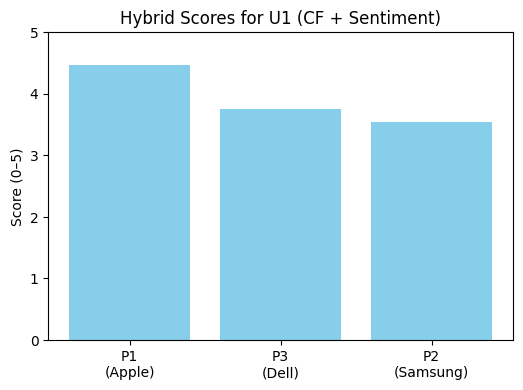

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# 1️⃣ Dataset with brand info
data = {
    'userID':   ['U1','U1','U2','U2','U3','U3'],
    'productID':['P1','P2','P1','P3','P2','P3'],
    'brand':    ['Apple','Samsung','Apple','Dell','Samsung','Dell'],
    'rating':   [5,3,4,2,2,5],
    'review': [
        "Love this product! Works perfectly.",
        "It's okay, not great.",
        "Good quality but a bit expensive.",
        "Not what I expected, quite bad.",
        "Decent but could be better.",
        "Absolutely fantastic, highly recommend!"
    ]
}
df = pd.DataFrame(data)

# 2️⃣ Sentiment analysis
sa = pipeline("sentiment-analysis",
              model="distilbert-base-uncased-finetuned-sst-2-english")
res = sa(df["review"].tolist())
# Convert to positive 0-1 scale
df["sentiment"] = [r["score"] if r["label"]=="POSITIVE" else 1-r["score"] for r in res]

# 3️⃣ Collaborative filtering
reader = Reader(rating_scale=(1,5))
data_surp = Dataset.load_from_df(df[["userID","productID","rating"]], reader)
train, test = train_test_split(data_surp, test_size=0.3, random_state=42)

algo = SVD(n_factors=10, n_epochs=20, random_state=42)
algo.fit(train)
preds = algo.test(test)
accuracy.rmse(preds)

# 4️⃣ Hybrid recommendation for U1
alpha = 0.7
user = "U1"
scores = []
for pid in df["productID"].unique():
    cf = algo.predict(user, pid).est
    sent = df.loc[df["productID"]==pid, "sentiment"].mean()
    final = alpha*cf + (1-alpha)*(sent*5)  # scale 0–1 sentiment to 0–5
    brand = df.loc[df["productID"]==pid, "brand"].iloc[0]
    scores.append((pid, brand, final))
scores.sort(key=lambda x:x[2], reverse=True)

print(f"Top products for {user}:")
for pid, brand, sc in scores:
    print(f"{pid} ({brand}) → {sc:.2f}")

# 5️⃣ Bar chart of Hybrid Scores per Product
labels = [f"{pid}\n({brand})" for pid, brand, _ in scores]
values = [sc for _, _, sc in scores]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color='skyblue')
plt.title(f"Hybrid Scores for {user} (CF + Sentiment)")
plt.ylabel("Score (0–5)")
plt.ylim(0,5)
plt.xticks(rotation=0)
plt.show()
